# Pytorch and XGBoost Classification (without distributed computing)

The notebook below demonstrates a typical single-PC approach to image classification tasks in both XGBoost and PyTorch. 

We will use these results as a benchmark of sorts against which we can compare the distributed computing methods we would use with very large datasets. 

Without prolonged access to a proper GPU cluster, fair comparisons of processing speed gains will not be possible -- however, we can still take note of the differences in approach whenever they arise, and draw reasonable conclusions about the likely effects of those differences.

RESOURCES AND CITATIONS

[PyImageSearch](https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/)

[Prof. Chinmay Hegde](https://github.com/chinmayhegde/dl-demos/)

[RasterIO](https://rasterio.readthedocs.io/en/latest/)

DATASETS

[Ground-level Fire](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-fire-detection/keras-fire-detection.zip)

[FLAME UAV Aerial Fire](https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs)

[LANDSAT-8 Active Fire](https://ieee-dataport.org/open-access/large-scale-dataset-active-fire-detectionsegmentation-landsat-8#files)

# Setup

These cells must be run first, and should be run before attempting to run any of the classification cells below.

Note also that you will need to adjust the PATH variables to point to your own copies of the datasets -- links to the datasets used are available in the cell above.

In [1]:
!nvidia-smi

Mon Dec  6 10:37:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install rasterio ipython-autotime pymongo[tls,srv]
%load_ext autotime

time: 309 µs (started: 2021-12-06 10:37:27 +00:00)


In [3]:
import warnings
warnings.filterwarnings("ignore")

time: 1.3 ms (started: 2021-12-06 10:37:27 +00:00)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 24.7 s (started: 2021-12-06 10:37:27 +00:00)


Now we're going to enable saving our results to our MongoDB remote database! First we import the client using pymongo --

In [5]:
from pymongo import MongoClient
uri = "mongodb+srv://baffree.pm9ae.mongodb.net/myFirstDatabase?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/drive/MyDrive/Vault/Mongo/X509-cert-7734489939085958648.pem')
db = client['bd']
collection = db['pt_xgb']

time: 8.49 s (started: 2021-12-06 10:37:52 +00:00)


Then we make sure that we have the necessary settings to connect --

In [6]:
!python -c "import ssl; print(getattr(ssl, 'HAS_SNI', False))"

True
time: 122 ms (started: 2021-12-06 10:38:01 +00:00)


In [7]:
!openssl version

OpenSSL 1.1.1  11 Sep 2018
time: 116 ms (started: 2021-12-06 10:38:01 +00:00)


In [8]:
!python -c "import requests; print(requests.get('https://www.howsmyssl.com/a/check', verify=False).json()['tls_version'])"

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
TLS 1.3
time: 918 ms (started: 2021-12-06 10:38:01 +00:00)


If we hit a connection error, we have to check that our cluster is open to connection from this IP. We can change this setting in MongoDB Atlas --

1. From our Atlas cluster, visit Network Access
2. Open 0.0.0.0/0 (for a day at most, this is highly insecure)

Then we wait for changes to propagate.

In [9]:
try:
  test_doc = {"name" : "test"}
  collection.insert_one(test_doc)
  print("insertion complete")
  query = {"name": "test"}
  cursor = collection.find(query)
  for document in cursor:
        print(document)
  d = collection.delete_many(query)
  print(d.deleted_count, " documents deleted !!")
except:
  print("check mongoDB connection")

insertion complete
{'_id': ObjectId('61ade80a082b52210af624dc'), 'name': 'test'}
1  documents deleted !!
time: 1.38 s (started: 2021-12-06 10:38:02 +00:00)


In [10]:
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"

time: 893 µs (started: 2021-12-06 10:38:03 +00:00)


# XGBoost Setup (run me first)

XGBoost is an extremely popular library on Kaggle, and is frequently the weapon of choice for classification tasks in machine learning. It uses what is today considered a slightly 'retro' technique called [gradient boosted trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). Although the approach isn't novel, it is extremely powerful for several reasons --

1. It is explainable: it's very easy to see why an XGBoost model is making the decisions it is making
2. It is fast: boosted trees are a lot more efficient than many of the massive, complex model architectures which dominate today's research.
3. It is flexible: XGBoost can handle most tabular-format data with ease. Its interface is based on the well-known sklearn family of libraries, which is familiar to many in data science. And it's very straightforward to use techniques like k-fold cross-validation.

Last but not least, at least not for our purposes, XGBoost is tightly integrated with Dask, making it an ideal candidate for distributed computing experiments. 

In [ ]:
import cv2
import rasterio
from rasterio.plot import show
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
from imutils import paths
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import numpy as np
import imutils
import random
import cv2
import sys
import os

time: 708 ms (started: 2021-12-05 02:42:38 +00:00)


# Image Classification: XGBoost, Ground-Level Fire Imagery

**DATASET NOTES**

The dataset we’ll be using for fire and smoke examples was curated by PyImageSearch reader, Gautam Kumar.

Guatam gathered a total of 1,315 images by searching Google Images for queries related to the term “fire”, “smoke”, etc.

However, the original dataset has not been cleansed of extraneous, irrelevant images that are not related to fire and smoke (i.e., examples of famous buildings before a fire occurred).

Fellow PyImageSearch reader, David Bonn, took the time to manually go through the fire/smoke images and identify ones that should not be included.

The dataset we’ll be using for Non-fire examples is called 8-scenes as it contains 2,688 image examples belonging to eight natural scene categories (all without fire).

The images are in RGB colorspace, JPEG format, with 256x256 resolution.

The image classes are imbalanced in favor of non-fire samples, reflecting the distribution of data we would expect to encounter in the real world.

## Setup

Since XGBoost expects tabular data, we will treat each pixel as a feature. This approach loses all contextual information, of course -- XGBoost's classifier isn't going to be able to learn the same visual feature and apply it to different areas of the image, as the PyTorch classifiers will. For that reason, we should expect somewhat poorer accuracy from XGBoost, but better speed and explainability.

In [ ]:
class Config:
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/Robbery_Accident_Fire_Database2",
        "Fire"])
    NON_FIRE_PATH = "/content/drive/MyDrive/datasets/spatial_envelope_256x256_static_8outdoorcategories"
    
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    MAX_SAMPLES = 1300
    CROSSVAL = 2
    
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = .01
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "fire_detection.model"])
    
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "lrfind_plot.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "training_plot.png"])

    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "examples"])
    SAMPLE_SIZE = 50

# initialize the configuration object
config = Config()

time: 12.8 ms (started: 2021-12-05 02:42:47 +00:00)


In [ ]:
def load_dataset(datasetPath, shape, max_samples):
  # grab the paths to all images in our dataset directory, then
  # initialize our lists of images
  imagePaths = list(paths.list_images(datasetPath))
  data = []

  # loop over the image paths, limiting size of dataset to 1300 samples per class
  count = 0
  for imagePath in tq.tqdm(imagePaths):
    count += 1
    # if count > max_samples:
    #   print("breaking at {}".format(max_samples))
    #   break
    # ignoring aspect ratio
    image = cv2.imread(imagePath)
    # load the image and resize it to be a fixed 128x128 pixels
    image = cv2.resize(image, (128, 128))
    if shape == "row":
      image = np.asarray(image).flatten()
    # add the image to the data lists
    data.append(image)

  # return the data list as a NumPy array
  np_data = np.array(data, dtype="float32")
  # Scale to [0,1]
  np_data /= 255
  return np_data

time: 9.37 ms (started: 2021-12-05 02:42:48 +00:00)


## Train, Test

In [ ]:
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH, "row", config.MAX_SAMPLES)
nonFireData = load_dataset(config.NON_FIRE_PATH, "row", config.MAX_SAMPLES)
# stack the fire data with the non-fire data
data = np.vstack([fireData, nonFireData])
labels_np = np.hstack([np.ones((fireData.shape[0],)), np.zeros((nonFireData.shape[0],))])

[INFO] loading data...


  0%|          | 0/1315 [00:00<?, ?it/s]

  0%|          | 0/2688 [00:00<?, ?it/s]

time: 47.7 s (started: 2021-12-05 02:42:48 +00:00)


In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels_np,
	test_size=config.TEST_SPLIT, shuffle=True)

time: 236 ms (started: 2021-12-05 02:43:35 +00:00)


In [ ]:
start_time = time.time()

# fit a Xgboost model to the data
# TODO: optimize params, learning rate, save model weights
model = xgb.XGBClassifier()

cv_results = cross_val_score(model, trainX, trainY, 
                cv = config.CROSSVAL, scoring='accuracy', n_jobs = -1, verbose = 1)    

model.fit(trainX, trainY, verbose=True)

print(); print("XGB_Classifier accuracy is {}, {}".format(cv_results[0], cv_results[1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.1min finished



XGB_Classifier accuracy is 0.8027981345769487, 0.8154563624250499
time: 14min 26s (started: 2021-12-05 02:43:36 +00:00)


In [ ]:
# make predictions
expected_y = testY
predicted_y = model.predict(testX)

from datetime import datetime

cur_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

keystr = "xgb_ground_" + cur_time

classif = metrics.classification_report(expected_y, predicted_y)

conf = metrics.confusion_matrix(expected_y, predicted_y)

rtime = time.time() - start_time

results = {"name" : keystr, "classifier" : "xgboost", "dataset" : "ground", "metric" : classif, "confmatrix" : conf, "runtime" : rtime, "train_test_split" : config.TEST_SPLIT, "cross_val" : config.CROSSVAL}

#store in mongoDB (timeout error)
# collection.insert_one(results)

#store to local pickle
import pickle

PICKLE_FILE = keystr + ".pkl"

PICKLE_PATH = os.path.join(PATH, PICKLE_FILE)

with open(PICKLE_PATH, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# summarize the fit of the model
print(); print(classif)
print(); print(conf)

print()
print("Execution Time %s seconds: " % (rtime)) 


              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       666
         1.0       0.80      0.59      0.68       335

    accuracy                           0.81      1001
   macro avg       0.81      0.76      0.78      1001
weighted avg       0.81      0.81      0.81      1001


[[616  50]
 [136 199]]

Execution Time 918.0609667301178 seconds: 
time: 463 ms (started: 2021-12-05 02:58:53 +00:00)


The accuracy we see here is good, but not quite on the level of what convnets are able to achieve.

# Image Classification: XGBoost, LANDSAT-8 Imagery

**DATASET NOTES**

This dataset was created from all Landsat-8 images from South America in the year 2018. More than 31 thousand images were processed (15 TB of data), and approximately on half of them active fire pixels were found.

The images in our dataset are in TIFF (geotiff) format with 10 bands (excluding the 15m panchromatic band). We cropped the original Landsat-8 scenes into image patches with 128 x 128 pixels by using a stride overlap of 64 pixels (vertical and horizontal). The masks are in binary format where True (1) represents fire and False (0) represents background and they were generated from the conditions set by Schroeder et al. (2016).

The full size of this dataset is hundreds of gigabytes -- we don't want to try to analyze that much data on a single colab instance! Instead, we're going to use just a small subset of the images as a proof of concept.

## Setup

In [ ]:
class Config:
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Training",
        "Fire"])
    FIRE_TEST_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Test",
        "Fire"])
    NON_FIRE_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Training", "No_Fire"])
    NON_FIRE_TEST_PATH = os.path.sep.join(["/content/drive/MyDrive/datasets/landsat_mini/Test", "No_Fire"])

    
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    MAX_SAMPLES = 1300
    CROSSVAL = 2
    
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = .01
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "fire_detection_xgb_landsat.model"])
    
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "lrfind_plot_xgb_landsat.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "training_plot_xgb_landsat.png"])

    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/", "examples"])
    SAMPLE_SIZE = 50

# initialize the configuration object
config = Config()

time: 14.7 ms (started: 2021-12-05 02:59:40 +00:00)


Images in GeoTIFF format present some unique advantages, as well as challenges, when it comes to image classification. There's a wealth of data available -- instead of lossy-compressed JPEG format, we have uncompressed TIFF images. Instead of 3-channel RGB, we have 10-band multispectral imaging. And we get all of that at a massive 8000x8000 resolution. GeoTIFFs are also rich in metadata, tagged with features like longitude and latitude.

But all of that data comes at a price in both space and time complexity -- unedited GeoTIFF images are not suitable for machine learning. There's simply too much data, most of which is irrelevant for the purposes of fire detection.

In this dataset, the GeoTIFFs were preprocessed to 128x128 px patches, but we will need to do additional processing before our classifiers are able to analyze the data. A python module called **RasterIO** will convert the GeoTIFF format to something readable by the usual suspects in Python image processing, including **PIL**, which is used under-the-hood by PyTorch to perform its Tensor transforms. 

Once again, XGBoost doesn't know or care that it is dealing with an image -- as far as XGBoost is concerned, this is just another table of feature values (stored in a Numpy array) which happen to be floats ranging from 0 to 1.

Following the authors of the [paper](https://github.com/pereira-gha/activefire) from which this dataset was derived, our classifiers will focus on bands 2, 6 and 7.

In [ ]:
def load_dataset(datasetPath, shape, max_samples):
  # grab the paths to all images in our dataset directory, then
  # initialize our lists of images
  imagePaths = list(paths.list_images(datasetPath))
  data = []

  # loop over the image paths, limiting size of dataset to 1300 samples per class
  count = 0
  for imagePath in tq.tqdm(imagePaths):
    count += 1
    if count > max_samples:
      print("breaking at {}".format(max_samples))
      break
    # ignoring aspect ratio
    img = rasterio.open(imagePath)
    image = rasterio.plot.reshape_as_image(img.read((2,6,7)))
    if shape == "row":
      image = image.flatten()
    # add the image to the data lists
    data.append(image)

  # return the data list as a NumPy array
  np_data = np.array(data, dtype="float32")
  print(np_data.shape)
  # Scale to [0,1]
  np_data /= (np_data.max()-np_data.min())
  return np_data

time: 11.2 ms (started: 2021-12-05 02:59:40 +00:00)


## Train, Test

Since this approach handles the train-test split within the model setup itself, we can simply treat the two folders as if they were one for the purposes of loading the data -- this will not be the case when we use PyTorch.

In [ ]:
# load the fire and non-fire images
# TODO: use test data, not just train, use all samples
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH, "row", config.MAX_SAMPLES) + load_dataset(config.FIRE_TEST_PATH, "row", config.MAX_SAMPLES)
nonFireData = load_dataset(config.NON_FIRE_PATH, "row", config.MAX_SAMPLES) + load_dataset(config.NON_FIRE_TEST_PATH, "row", config.MAX_SAMPLES)
# stack the fire data with the non-fire data
data = np.vstack([fireData, nonFireData])
labels_np = np.hstack([np.ones((fireData.shape[0],)), np.zeros((nonFireData.shape[0],))])

[INFO] loading data...


  0%|          | 0/645 [00:00<?, ?it/s]

(645, 49152)


  0%|          | 0/497 [00:00<?, ?it/s]

(497, 49152)
time: 6min 45s (started: 2021-12-05 02:59:40 +00:00)


In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels_np,
	test_size=config.TEST_SPLIT, shuffle=True)

time: 53.7 ms (started: 2021-12-05 03:06:25 +00:00)


In [ ]:
start_time = time.time()

# fit a Xgboost model to the data
# TODO: optimize params, learning rate, save model weights
model = xgb.XGBClassifier()

cv_results = cross_val_score(model, trainX, trainY, 
                cv = config.CROSSVAL, scoring='accuracy', n_jobs = -1, verbose = 1)    

model.fit(trainX, trainY, verbose=True)

print(); print("XGB_Classifier accuracy is {}, {}".format(cv_results[0], cv_results[1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min finished



XGB_Classifier accuracy is 0.7990654205607477, 0.8154205607476636
time: 6min 51s (started: 2021-12-05 03:06:25 +00:00)


In [ ]:
# make predictions
expected_y = testY
predicted_y = model.predict(testX)

from datetime import datetime

cur_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

keystr = "xgb_satellite_" + cur_time

classif = metrics.classification_report(expected_y, predicted_y)

conf = metrics.confusion_matrix(expected_y, predicted_y)

rtime = time.time() - start_time

results = {"name" : keystr, "classifier" : "xgboost", "dataset" : "satellite", "metric" : classif, "confmatrix" : conf, "runtime" : rtime, "train_test_split" : config.TEST_SPLIT, "cross_val" : config.CROSSVAL}

#store in mongoDB (timeout error)
collection.insert_one(results)

#store to local pickle
import pickle

PICKLE_FILE = keystr + ".pkl"

PICKLE_PATH = os.path.join(PATH, PICKLE_FILE)

with open(PICKLE_PATH, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# summarize the fit of the model
print(); print(classif)
print(); print(conf)

print()
print("Execution Time %s seconds: " % (rtime)) 


              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       132
         1.0       0.78      0.83      0.81       154

    accuracy                           0.78       286
   macro avg       0.78      0.78      0.78       286
weighted avg       0.78      0.78      0.78       286


[[ 96  36]
 [ 26 128]]

Execution Time 411.54333424568176 seconds: 
time: 148 ms (started: 2021-12-05 03:13:17 +00:00)


XGBClassifier performs unusally well on this data -- better, in fact, than the convnets. There are many possible explanations, but the most likely one, with such a small sample size, is sheer luck.

Even so, this does suggest that XGBoost shouldn't be counted out as an image classifier.

Again, the accuracy values aren't going to be completely reliable, since this is a project more oriented towards Big Data questions than pure Deep Learning questions.

# Pytorch; Wide Resnet-50, Densenet 161 Setup

PyTorch, created by The Company Formerly Known As Facebook, is one of the two most popular frameworks today for deep learning, the other being Google's Tensorflow.

PyTorch is versatile, contains many useful abstractions to make training deep learning models much easier, and includes built-in support for distributed data processing, as we will see later.

However, it is a very elaborate framework, with many features and quirks to learn. Its syntax does not resemble that of any other commonly used library, and there aren't a lot of best practices yet in place for making PyTorch code reusable and readable, although we'll see one promising approach in the next notebook.

In [11]:
import rasterio
from rasterio.plot import show
import PIL
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import scipy.ndimage
import tqdm.notebook as tq
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision import datasets, models, transforms
from torch.utils.data.dataloader import default_collate
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import numpy as np
import zipfile

import os
import time
from datetime import datetime
import pickle

%matplotlib inline

time: 6.79 s (started: 2021-12-06 10:38:10 +00:00)


# Image Classification: Ground-Level Fire Images

## Setup

Unlike XGBoost, PyTorch ingests data through its own specialized class, the DataLoader. In the case of image classification, the DataLoader can make use of an additional class called ImageFolder. We will use PyTorch ImageFolders, since they are the recommended way to handle image data in PyTorch.

All pre-trained PyTorch models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. To maximize accuracy, pixels in the image are typically scaled to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

torchvision.transforms.ToTensor implicitly divides by 255, so we don't need to do that step in PyTorch as we did in XGBoost. We will need to do additional scaling, however, when we work with the GeoTIFF images, since they're on a completely different scaling index than typical images.

In [ ]:
"""
CONFIG CELL
"""
#Batch size with gradient accumulation
accum_iter = 4
BATCH_SIZE = 8
ACTUAL_BATCH_SIZE = BATCH_SIZE * max(accum_iter, 1)
#model names and path
pt_models = [models.densenet161(pretrained=True), models.wide_resnet50_2(pretrained=True)]
model_names = ["groundfire_densenet161", "groundfire_wide_resnet50_2"]
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"

PREV_ACC = 0
LR = 0.001
epochs = 3

#Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

start_time = time.time()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

time: 4.26 s (started: 2021-12-05 14:38:36 +00:00)


In [ ]:
# data transforms
dset_transform = transforms.Compose([
        transforms.Resize((256,256), interpolation=PIL.Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"/content/drive/MyDrive/datasets/fire_ground_level/{x}", dset_transform) for x in ['Training', 'Test', 'Validation']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE, shuffle=(x == "Training"))
               for x in ['Training', 'Test', 'Validation']}

time: 11.2 s (started: 2021-12-05 14:38:40 +00:00)


## Dataset Visualization

Let's visualize a few of the images from this dataset, to get a feel for them.

In [ ]:
img = cv2.imread('/content/drive/MyDrive/datasets/fire_ground_level/Training/fire/105.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img = cv2.imread('/content/drive/MyDrive/datasets/fire_ground_level/Training/fire/301.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

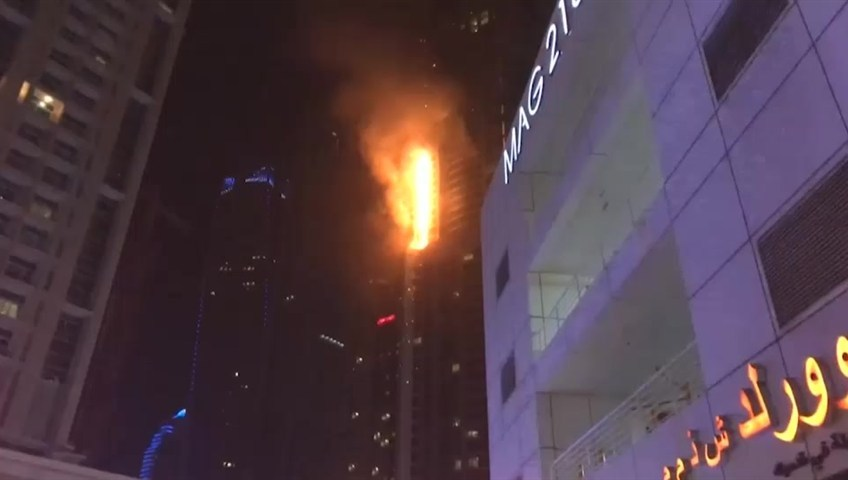

time: 708 ms (started: 2021-12-05 11:32:48 +00:00)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/datasets/fire_ground_level/Training/fire/203.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Because the dataset was scraped from the internet and then released by a popular online website, it has samples which depict fires that have already burned out, and images that have watermarks on them.

We wouldn't want to do serious research work with this dataset, but for the purposes of testing our models, it is clean enough.

In [ ]:
"""
filtered_images expects torch tensors of dimension [channels, horiz, vert], will reshape
"""

def plot_filter(images, filtered_images):
    
    n_images = images.shape[0]

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        show_img = images[i].squeeze(0)
        show_img = torch.swapaxes(show_img, 0, 1)
        show_img = torch.swapaxes(show_img, 1, 2)
        #bring minimum value to 0 and scale to [0,1] for matplotlib
        #print("before scaling")
        #print(torch.max(show_img), torch.min(show_img))
        show_img = torch.add(show_img, torch.abs(torch.min(show_img)))
        #print("raise floor")
        #print(torch.max(show_img), torch.min(show_img))
        #print("rescale to [0,1]")
        show_img /= (torch.max(show_img)-torch.min(show_img))
        #print(torch.max(show_img), torch.min(show_img))
        ax.imshow(show_img, cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Output')
        ax.axis('off');

time: 27.4 ms (started: 2021-12-05 11:32:48 +00:00)


We can use the above standard-issue image plotting function to visualize some of the images in our dataset.

In [ ]:
image, label = next(iter(dataloaders["Training"]))

time: 18.1 s (started: 2021-12-05 11:32:49 +00:00)


In [ ]:
num_images = len(image)
images = []
for i in range(num_images):
  images.append(image[i])
  print(torch.max(image[i]), torch.min(image[i]))

tensor(2.6400) tensor(-2.1179)
tensor(2.4657) tensor(-2.1179)
tensor(2.3585) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.5703) tensor(-1.8044)
tensor(2.2489) tensor(-2.0357)
tensor(2.6400) tensor(-2.1179)
tensor(2.6400) tensor(-2.0837)
tensor(2.6400) tensor(-2.1179)
tensor(2.5529) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.4483) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.2535) tensor(-2.1179)
tensor(2.4657) tensor(-2.1179)
tensor(2.6400) tensor(-2.0837)
tensor(2.6400) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.3585) tensor(-2.1179)
tensor(2.3936) tensor(-1.8044)
tensor(2.6400) tensor(-2.1179)
tensor(2.3786) tensor(-2.1179)
tensor(2.5703) tensor(-2.0357)
tensor(2.4286) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.4657) tensor(-1.5185)
tensor(2.6400) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.4286) tensor(-2.1179)
tensor(2.6400) tensor(-2.1179)
tensor(2.4286) tensor(-2.1179)
time: 65

Let's convert to a Torch tensor by adding a singleton dimension.

In [ ]:
images = torch.cat([img.unsqueeze(0) for img in images], dim = 0)

time: 10 ms (started: 2021-12-05 11:33:07 +00:00)


Let's examine these images, and while we're at it, let's take a glance at how our convolutional filter is going to process them. 

In [ ]:
filter = [[[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]]]
filter = torch.FloatTensor(filter).unsqueeze(0)

time: 5.79 ms (started: 2021-12-05 11:33:07 +00:00)


The correct size for a conv2d should be:

    input: (batch_size, in_channels , height, width)
    weight: (out_channels, in_channels , kernel_height, kernel_width)


In [ ]:
filtered_images = nn.functional.conv2d(images, filter, stride=(1, 1), padding=2, bias=None)
filtered_images.shape

torch.Size([32, 1, 256, 256])

time: 137 ms (started: 2021-12-05 11:33:07 +00:00)


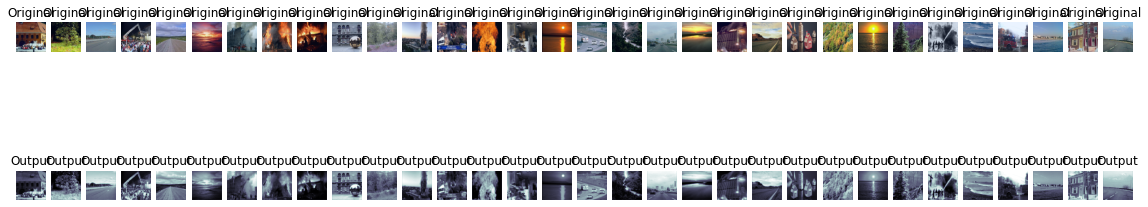

time: 2.44 s (started: 2021-12-05 11:33:07 +00:00)


In [ ]:
plot_filter(images, filtered_images)

We're seeing a lot more non-fire than fire samples here -- that's to be expected, since our non-fire dataset is twice as large! Notice that the convolution is able to capture a wide range of detail in the image, even at this relatively low resolution.

## Train and Test

In this project, we will be comparing two different convnet classifiers -- wide_resnet_50 and densenet161, across three different types of fire image data -- images of fires at ground level, images of fires from a UAV, and images of fires taken by a satellite. 

We chose these models because of their strong overall performance in classification tasks, as documented in this [comprehensive 2021 study](https://arxiv.org/abs/2110.07097).

In [ ]:
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

time: 994 ms (started: 2021-12-05 14:39:14 +00:00)


The results are, as expected, impressive. Training accuracy is in excess of 99 percent during the most successful epochs, and even without choosing the best model, test accuracy is 88 percent for wide_resnet, almost 10 points higher than xgboost. Densenet performs better still, exceeding 94 percent accuracy.

That said, the increased accuracy comes at a cost -- wide_resnet is more than ~4x slower to train than XGBClassifier, and densenet is ~2x slower. Although this is not the most optimized possible approach for any of these three models, this time differential is not atypical. Techniques like early stopping are a big time-saver on relatively simple datasets like this one -- for both models, 10 epochs looks to be overkill, and quite possibly overfitting.

Another major consideration is the heavy demands placed on the GPU by training large convnets -- in an interactive environment like Colab, where variables are not released from memory, this means we need to reset the environment more or less every time before training a new model.

In fact, this is one of the major promises of distributed computing -- in theory, distributed frameworks allow CUDA memory to 'spill over' into conventional RAM storage, and allow large datasets to be divided between multiple GPUs on multiple nodes.

Model is now groundfire_densenet161
Number of batches: Test: 59


0it [00:00, ?it/s]

Phase:Test -- Loss:0.04 -- Acc:98.71
Model is now groundfire_wide_resnet50_2


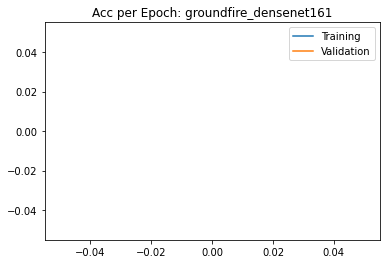

time: 13.8 s (started: 2021-12-05 14:48:20 +00:00)


In [ ]:
for i, model in enumerate(pt_models):
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
    #Use pre-loaded model T/F
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/groundfire_wide_resnet50_2/groundfire_wide_resnet50_2.pt"
    LOAD_MODEL = False
    #Skip this model T/F
    SKIP_MODEL = True

  if i == 0:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
    #Use pre-loaded model T/F
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/groundfire_densenet161/groundfire_densenet161.pt"
    LOAD_MODEL = True
    #Skip this model T/F
    SKIP_MODEL = False
  if SKIP_MODEL:
    continue
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  LR = .001
  optimizer = optim.Adam(model.parameters(), lr=LR)
  save_loss = {'Training':[], 'Validation':[], 'Test':[]}
  save_acc = {'Training':[], 'Validation':[], 'Test':[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  for epoch in range(epochs):
      if LOAD_MODEL:
        model.load_state_dict(torch.load(MODEL_PATH))
        model = model.to(device)
        break
      model = model.to(device)
      # Each epoch has a train and validation phase
      for phase in ['Training', 'Validation']:
          if phase == 'Training':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          current_loss = 0.0
          current_corrects = 0
          print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
          for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
              inputs = inputs.to(device)
              labels = labels.to(device)
              # Time to carry out the forward training poss
              with torch.set_grad_enabled(phase == 'Training'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'Training':
                      loss.backward()
                      if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(dataloaders[phase])):
                        optimizer.step()
                        optimizer.zero_grad()

              # We want variables to hold the loss/acc statistics
              current_loss += loss.item() * inputs.size(0)
              current_corrects += torch.sum(preds == labels.data)
          # saving variable for plottin
          save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
          save_acc[phase] += [current_corrects.item() / len(dataloaders[phase].dataset)]

          # pretty print
          print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = "Test"
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
      # saving variable for plottin
  save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
  save_acc[phase] += [current_corrects.item() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc['Training'])
  plt.plot(save_acc['Validation'])
  plt.legend(["Training", "Validation"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)

  cur_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

  keystr = model_names[i] + cur_time

  rtime = time.time() - start_time

  start_time = time.time()

  results = {"name" : keystr, "classifier" : model_names[i], "dataset" : "ground", "distributed" : False, "loss_dict" : save_loss, "acc_dict" : save_acc, "runtime" : rtime, "epochs" : epochs, "LR" : LR, "Optim" : "Adam", "batch_size" : ACTUAL_BATCH_SIZE, "Gradient Accumulation" : ACTUAL_BATCH_SIZE > BATCH_SIZE, "Skip Training" : LOAD_MODEL}

  #store in mongoDB
  collection.insert_one(results)

  #store results pickle locally for later upload
  PICKLE_FILE = keystr + ".pkl"

  PICKLE_PATH = os.path.join(PATH, model_names[i], PICKLE_FILE)

  with open(PICKLE_PATH, 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results

### Resnet

The resnet model performed well on this dataset, with errors leaning towards false positives. It performed well enough that we can expect that a model trained on a superior dataset would probably also be pretty successful at this task.

This makes sense -- ground-level fire detection should be the easiest of the three tasks, and our data thus far seems to bear that out.

In [ ]:
model = models.wide_resnet50_2(pretrained=True)
num_ftrs = model.fc.in_features ### Resnet Wide
model.fc = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/groundfire_wide_resnet50_2/groundfire_wide_resnet50_2.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
labels, probs = get_predictions(model, dataloaders["Test"], device)

In [ ]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

The resnet model performed well on this dataset, with errors leaning towards false positives. It performed well enough that we can expect that a model trained on a superior dataset would probably also be pretty successful at this task.

This makes sense -- ground-level fire detection should be the easiest of the three tasks, and our data thus far seems to bear that out.

### Densenet

Densenet turns in spectacular performance on this dataset, at least as far as classification accuracy is concerned.

This makes sense -- ground-level fire detection should be the easiest of the three tasks, and our data thus far seems to bear that out.

In [ ]:
model = models.densenet161(pretrained=True)
num_ftrs = model.classifier.in_features ### Densenet161
model.classifier = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/groundfire_densenet161/groundfire_densenet161.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

time: 1.08 s (started: 2021-12-05 14:55:26 +00:00)


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

time: 10.8 ms (started: 2021-12-05 14:55:27 +00:00)


In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

time: 2.33 ms (started: 2021-12-05 14:55:27 +00:00)


In [ ]:
labels, probs = get_predictions(model, dataloaders["Test"], device)

time: 9.86 s (started: 2021-12-05 14:55:27 +00:00)


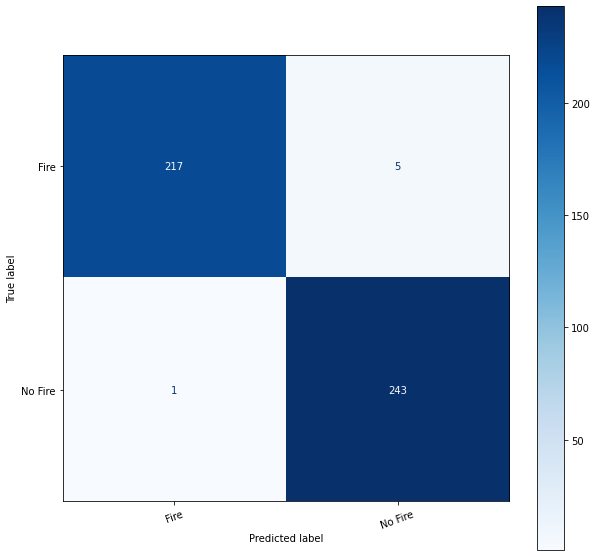

time: 198 ms (started: 2021-12-05 14:55:37 +00:00)


In [ ]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

# Image Classification: Aerial Fire Imagery

**DATASET NOTES**

This study provides an aerial imagery FLAME (Fire Luminosity Airborne-based Machine learning Evaluation) dataset using drones during a prescribed pile burn in Northern Arizona, USA. This dataset consists of different repositories including raw aerial videos recorded by drones' cameras and also raw heatmap footage recorded by an infrared thermal camera. To help researchers, two well-known studies; fire classification and fire segmentation are defined based on the dataset. For approaches such as Neural Networks (NNs) and fire classification, 39,375 frames are labeled ("Fire" vs "Non-Fire") for the training phase. Also, another 8,617 frames are labeled for the test data. 2,003 frames are considered for the fire segmentation and regarding that, 2,003 masks are generated for the purpose of Ground Truth data with pixel-wise annotation.

The images are in RGB colorspace, JPEG format, with 254x254 resolution.

## Setup

With considerably more data to process, this model trains more slowly than the groundfire model. But it also shows extremely high accuracy from the very first epoch -- arguably, even three epochs here is overkill.

We're also going to use gradient accumulation in order to avoid overflowing our VRAM while keeping the batch size relatively high (for better accuracy).

In [12]:
"""
CONFIG CELL
"""

#Batch size with gradient accumulation
accum_iter = 4
BATCH_SIZE = 8
ACTUAL_BATCH_SIZE = BATCH_SIZE * max(accum_iter, 1)
#model names and path
pt_models = [models.densenet161(pretrained=True), models.wide_resnet50_2(pretrained=True)]
model_names = ["aerialfire_densenet161", "aerialfire_wide_resnet50_2"]
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"

PREV_ACC = 0
LR = 0.001
epochs = 3

#Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

start_time = time.time()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

time: 5.23 s (started: 2021-12-06 10:38:24 +00:00)


In [13]:
#create save dirs
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

time: 1.71 s (started: 2021-12-06 10:38:29 +00:00)


In [14]:
# Acquire the zip file and decompress it in Colab
COLAB_PATH = os.path.join(".", "FLAME")
if not os.path.exists(COLAB_PATH):
  os.mkdir(COLAB_PATH)
FILE_PATH = os.path.join("/content/drive/MyDrive/datasets/", "FLAME.zip")
with zipfile.ZipFile(FILE_PATH,"r") as z:
  z.extractall(COLAB_PATH)
COLAB_PATHS = [os.path.join(COLAB_PATH, x) for x in ['Training', 'Test']]

time: 38.1 s (started: 2021-12-06 10:38:31 +00:00)


In [15]:
# data transforms
dset_transform = transforms.Compose([
        transforms.Resize((256,256), interpolation=PIL.Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ],
        )

categs = ["Training", "Test"]

# Use the image folder function to create datasets
dsets = {categs[i]: datasets.ImageFolder(f"{path}", dset_transform) for i, path in enumerate(COLAB_PATHS)}

# create data loader
dataloaders = {categs[i]: torch.utils.data.DataLoader(dsets[categs[i]], batch_size=BATCH_SIZE, shuffle=(i == 0))
               for i, path in enumerate(COLAB_PATHS)}


time: 281 ms (started: 2021-12-06 10:39:09 +00:00)


In [16]:
"""
DATALOADER SANITY CHECK
-2.5 ... 2.5
2
torch.Size([8, 3, 256, 256])
torch.Size([8])
tensor(0)
dtype = int64
time: 4.75 s (started: 2021-11-26 18:39:59 +00:00)
"""
try:
  sample = next(iter(dataloaders["Training"]))
  # print(sample)
  print(torch.max(sample[0]), torch.min(sample[0]))
  print(len(sample))
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1][1].dtype)
except:
  print("Seems there's an error with the dataloaders.")

tensor(2.6400) tensor(-2.0494)
2
torch.Size([8, 3, 256, 256])
torch.Size([8])
torch.int64
time: 128 ms (started: 2021-12-06 10:39:09 +00:00)


## Dataset Visualization

Let's visualize a few of the images from this dataset, to get a feel for them.

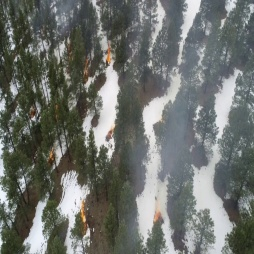

time: 86.8 ms (started: 2021-12-05 12:06:43 +00:00)


In [ ]:
img = cv2.imread('/content/FLAME/Training/Fire/resized_frame10076.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

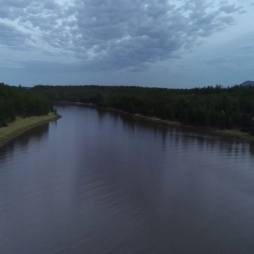

time: 36.3 ms (started: 2021-12-05 12:06:43 +00:00)


In [ ]:
img = cv2.imread('/content/FLAME/Training/No_Fire/lake_resized_lake_frame10112.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Here's a human-interpretable version of the image (once we scale the numbers, it won't look nearly so pretty). The fires and smoke in the Fire class are pretty easy to pick out from above, especially against the white snow. This shouldn't be too hard for a classifier, even without access to multispectral data.

In [ ]:
"""
filtered_images expects torch tensors of dimension [channels, horiz, vert], will reshape
"""

def plot_filter(images, filtered_images):
    
    n_images = images.shape[0]

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        show_img = images[i].squeeze(0)
        show_img = torch.swapaxes(show_img, 0, 1)
        show_img = torch.swapaxes(show_img, 1, 2)
        #bring minimum value to 0 and scale to [0,1] for matplotlib
        #print("before scaling")
        #print(torch.max(show_img), torch.min(show_img))
        show_img = torch.add(show_img, torch.abs(torch.min(show_img)))
        #print("raise floor")
        #print(torch.max(show_img), torch.min(show_img))
        #print("rescale to [0,1]")
        show_img /= (torch.max(show_img)-torch.min(show_img))
        #print(torch.max(show_img), torch.min(show_img))
        ax.imshow(show_img, cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Output')
        ax.axis('off');

time: 35.3 ms (started: 2021-12-05 12:06:43 +00:00)


We can use the above standard-issue image plotting function to visualize some of the images in our dataset.

In [ ]:
image, label = next(iter(dataloaders["Training"]))

time: 152 ms (started: 2021-12-05 12:06:43 +00:00)


In [ ]:
num_images = len(image)
images = []
for i in range(num_images):
  images.append(image[i])
  print(torch.max(image[i]), torch.min(image[i]))

tensor(0.7576) tensor(-1.8953)
tensor(2.6400) tensor(-2.0357)
tensor(2.5703) tensor(-1.9124)
tensor(2.6400) tensor(-2.0494)
tensor(2.6400) tensor(-2.0837)
tensor(2.5877) tensor(-1.7583)
tensor(2.6400) tensor(-1.6898)
tensor(2.6400) tensor(-1.7240)
tensor(2.6400) tensor(-2.0494)
tensor(2.3611) tensor(-1.8782)
tensor(1.7694) tensor(-1.8097)
tensor(2.6400) tensor(-1.9980)
tensor(2.5006) tensor(-1.8044)
tensor(2.6400) tensor(-2.0152)
tensor(2.6400) tensor(-1.8044)
tensor(2.6400) tensor(-1.8097)
tensor(2.6400) tensor(-1.9638)
tensor(2.6400) tensor(-1.7696)
tensor(2.6400) tensor(-1.8610)
tensor(2.5180) tensor(-1.8439)
tensor(2.5006) tensor(-1.6213)
tensor(2.5703) tensor(-1.7925)
tensor(2.5529) tensor(-1.8610)
tensor(2.4134) tensor(-1.8782)
tensor(2.6400) tensor(-2.1179)
tensor(2.6400) tensor(-1.7925)
tensor(2.5354) tensor(-1.7925)
tensor(1.8034) tensor(-1.9638)
tensor(2.6400) tensor(-1.7069)
tensor(2.6400) tensor(-1.7906)
tensor(2.5529) tensor(-1.9295)
tensor(1.4025) tensor(-1.8439)
time: 67

Let's convert to a Torch tensor by adding a singleton dimension.

In [ ]:
images = torch.cat([img.unsqueeze(0) for img in images], dim = 0)

time: 11.9 ms (started: 2021-12-05 12:06:43 +00:00)


Let's examine these images, and while we're at it, let's take a glance at how our convolutional filter is going to process them. 

In [ ]:
filter = [[[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]]]
filter = torch.FloatTensor(filter).unsqueeze(0)

time: 8.04 ms (started: 2021-12-05 12:06:43 +00:00)


The correct size for a conv2d should be:

    input: (batch_size, in_channels , height, width)
    weight: (out_channels, in_channels , kernel_height, kernel_width)


In [ ]:
filtered_images = nn.functional.conv2d(images, filter, stride=(1, 1), padding=2, bias=None)
filtered_images.shape

torch.Size([32, 1, 256, 256])

time: 205 ms (started: 2021-12-05 12:06:44 +00:00)


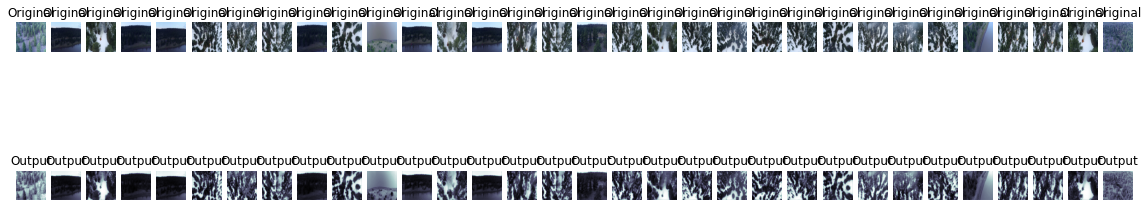

time: 2.73 s (started: 2021-12-05 12:06:44 +00:00)


In [ ]:
plot_filter(images, filtered_images)

## Train and Test

We can see that even with extremely high training accuracy, the model doesn't perform nearly as well with the test data (99% vs 81% accuracy). 

This might be because the samples we're using in FLAME are sort of unusual -- they aren't very diverse, which means our model may not be generalizing that well to new information.

Model is now aerialfire_densenet161
Number of batches: Training: 4922


0it [00:00, ?it/s]

Epoch:0 -- Phase:Training -- Loss:0.01 -- Acc:98.62
Number of batches: Training: 4922


0it [00:00, ?it/s]

Epoch:1 -- Phase:Training -- Loss:0.01 -- Acc:99.45
Number of batches: Test: 1078


0it [00:00, ?it/s]

Phase:Test -- Loss:1.10 -- Acc:78.91
Model is now aerialfire_wide_resnet50_2
Number of batches: Training: 4922


0it [00:00, ?it/s]

Epoch:0 -- Phase:Training -- Loss:0.02 -- Acc:97.68
Number of batches: Training: 4922


0it [00:00, ?it/s]

Epoch:1 -- Phase:Training -- Loss:0.01 -- Acc:98.94
Number of batches: Training: 4922


0it [00:00, ?it/s]

Epoch:2 -- Phase:Training -- Loss:0.01 -- Acc:99.39
Number of batches: Test: 1078


0it [00:00, ?it/s]

Phase:Test -- Loss:1.67 -- Acc:65.68


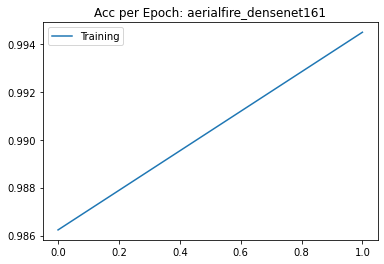

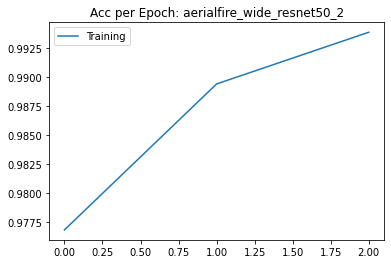

time: 1h 29min (started: 2021-12-06 10:39:31 +00:00)


In [17]:
for i, model in enumerate(pt_models):
  PREV_ACC = 0
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
    #Use pre-loaded model T/F
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/aerialfire_wide_resnet50_2/aerialfire_wide_resnet50_2.pt"
    LOAD_MODEL = False
    #Skip this model T/F
    SKIP_MODEL = False
  if i == 0:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/aerialfire_densenet161/aerialfire_densenet161.pt"
    LOAD_MODEL = False
    #Skip this model T/F
    SKIP_MODEL = False
  if SKIP_MODEL:
    continue
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=LR)
  save_loss = {'Training':[], 'Test':[]}
  save_acc = {'Training':[], 'Test':[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  model.train()
  phase = "Training"
  for epoch in range(epochs):
      if LOAD_MODEL:
        model.load_state_dict(torch.load(MODEL_PATH))
        model = model.to(device)
      #Early Stopping
      if LOAD_MODEL or (PREV_ACC > 99.0 and phase == "Training"):
        break
      model = model.to(device)
      current_loss = 0.0
      current_corrects = 0
      print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
      for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Time to carry out the forward training poss
          with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              # normalize loss to account for batch accumulation
              loss = loss / accum_iter 
              # backward pass
              loss.backward()
              if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(dataloaders[phase])):
                optimizer.step()
                optimizer.zero_grad()

          # We want variables to hold the loss/acc statistics
          current_loss += loss.item() * inputs.size(0)
          current_corrects += torch.sum(preds == labels.data)

      # saving variable for plotting
      save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[phase] += [current_corrects.item() / len(dataloaders[phase].dataset)]

      # pretty print
      print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
      PREV_ACC = save_acc[phase][-1]*100
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = "Test"
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      # backward pass
      loss.backward()
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
    # saving variable for plottin
  save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
  save_acc[phase] += [current_corrects.item() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc['Training'])
  plt.legend(["Training"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)

  cur_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

  keystr = model_names[i] + cur_time

  #log completion time
  rtime = time.time() - start_time

  #reset timer for next model
  start_time = time.time()

  results = {"name" : keystr, "classifier" : model_names[i], "dataset" : "aerial", "distributed" : False, "loss_dict" : save_loss, "acc_dict" : save_acc, "runtime" : rtime, "epochs" : epochs, "LR" : LR, "Optim" : "Adam", "batch_size" : ACTUAL_BATCH_SIZE, "Gradient Accumulation" : ACTUAL_BATCH_SIZE > BATCH_SIZE, "Skip Training" : LOAD_MODEL}

  #store in mongoDB
  collection.insert_one(results)

  PICKLE_FILE = keystr + ".pkl"

  PICKLE_PATH = os.path.join(PATH, model_names[i], PICKLE_FILE)

  with open(PICKLE_PATH, 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results

### Resnet

Let's run inference one more time on the test data, to get some additional insights.

In [19]:
%%capture
model = models.wide_resnet50_2(pretrained=True)
num_ftrs = model.fc.in_features ### Resnet Wide
model.fc = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/aerialfire_wide_resnet50_2/aerialfire_wide_resnet50_2.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

time: 1.94 s (started: 2021-12-06 12:20:21 +00:00)


In [20]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

time: 11.1 ms (started: 2021-12-06 12:20:23 +00:00)


In [21]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

time: 6.61 ms (started: 2021-12-06 12:20:23 +00:00)


In [22]:
labels, probs = get_predictions(model, dataloaders["Test"], device)

time: 49.6 s (started: 2021-12-06 12:20:23 +00:00)


In the confusion matrix, we can see that in the test data, our resnet model aggressively overpredicted fires. This may suggest that the model has overlearned certain features of this particular dataset that don't generalize well to all fires.

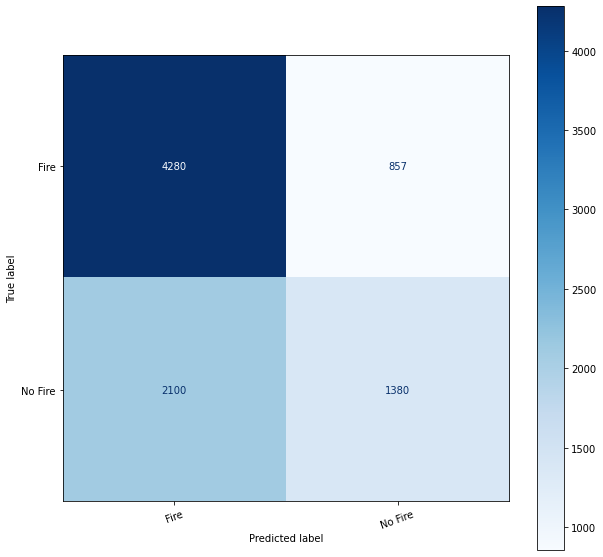

time: 285 ms (started: 2021-12-06 12:21:13 +00:00)


In [23]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

### Densenet

Densenet exhibits a similar bias to resnet, although less pronounced. Again, this suggests something amiss in the distribution of the underlying data between training and test.

In [24]:
%%capture
model = models.densenet161(pretrained=True)
num_ftrs = model.classifier.in_features ### Densenet161
model.classifier = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/aerialfire_densenet161/aerialfire_densenet161.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

time: 1.76 s (started: 2021-12-06 12:21:13 +00:00)


In [25]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

time: 10.3 ms (started: 2021-12-06 12:21:15 +00:00)


In [26]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

time: 4.79 ms (started: 2021-12-06 12:21:15 +00:00)


In [27]:
labels, probs = get_predictions(model, dataloaders["Test"], device)

time: 1min 2s (started: 2021-12-06 12:21:15 +00:00)


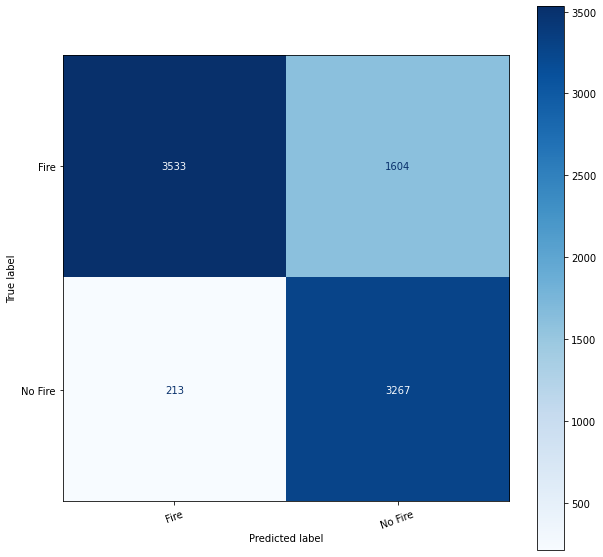

time: 278 ms (started: 2021-12-06 12:22:17 +00:00)


In [28]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

# Image Classification: Landsat-8 Imagery

We referred to the following tutorial when handling this dataset --

https://stackoverflow.com/questions/65621414/how-to-merge-two-torch-utils-data-dataloaders-with-a-single-operation

## Setup

In [ ]:
"""
CONFIG CELL
"""

#Batch size with gradient accumulation
accum_iter = 4
BATCH_SIZE = 8
ACTUAL_BATCH_SIZE = BATCH_SIZE * max(accum_iter, 1)
#model names and path
pt_models = [models.wide_resnet50_2(pretrained=True), models.densenet161(pretrained=True)]
model_names = ["satfire_wide_resnet50_2", "satfire_densenet161"]
PATH = r"/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project"

PREV_ACC = 0
LR = 0.001
epochs = 5

#Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

start_time = time.time()

time: 1.66 s (started: 2021-12-05 17:06:32 +00:00)


In [ ]:
folder_paths = ['/content/drive/MyDrive/datasets/landsat_mini/Training/Fire', '/content/drive/MyDrive/datasets/landsat_mini/Training/No_Fire', '/content/drive/MyDrive/datasets/landsat_mini/Test/Fire', '/content/drive/MyDrive/datasets/landsat_mini/Test/No_Fire']
data = [[] for i in range(len(folder_paths))]
labels = [np.array([0]), np.array([1])]
datasets = []
dataloaders = []
file = None
err_count = 0
ok_count = 0
for i, folder_path in enumerate(folder_paths):
  cum_diff = torch.tensor([0.])
  for file in os.listdir(folder_path):
    # try:
      # Interpret 10-band GeoTIFF using RasterIO
      try:
        file = rasterio.open(os.path.join(folder_path, file))
      except:
        err_count += 1
        continue
      # Possible bands: 2,3,6,7
      file = rasterio.plot.reshape_as_image(file.read((2,6,7)))
      # resize to 256x256 using bilinear interpolation
      file = scipy.ndimage.zoom(file, (2,2,1), order=1)
      # convert to Tensor
      x = torch.from_numpy(file.astype(np.int32))
      # normalize tensor to [-1, 1]
      cur_diff = (torch.abs(x.max())-torch.abs(x.min()))
      #print("curr_diff: {}".format(cur_diff))
      cum_diff = torch.mul(cum_diff, ok_count)
      # print("cum_diff step 1: ")
      # print(cum_diff)
      cum_diff = torch.add(cum_diff, cur_diff)
      cum_diff = torch.div(cum_diff, ok_count + 1)
      # print("cum_diff step 3: ")
      # print(cum_diff)
      MEAN = diff * torch.tensor([0.485, 0.456, 0.406])
      STD = diff * torch.tensor([0.229, 0.224, 0.225])
      x = x.type(torch.float32)
      x = x.permute(-1, 0, 1)
      x = (x - MEAN[:, None, None]) / STD[:, None, None]
      # print(x.shape, file.shape)
      # print(torch.min(x), torch.max(x))
      data[i].append(x)
      ok_count += 1
    # except:
    #   err_count += 1
  if not data[i]:
    print("No data found, iteration {}".format(i))
    continue
  x_t = torch.stack(data[i])
  y_t = torch.Tensor([labels[i % 2] for j in range(len(x_t))])
  y_t = y_t.type(torch.int64)
  y_t = y_t.squeeze()
  datasets.append(TensorDataset(x_t, y_t)) # create your datset
  if i % 2 == 1:
    dsab_cat = ConcatDataset([datasets[i-1], datasets[i]])
    dataloaders.append(DataLoader(dsab_cat, batch_size=BATCH_SIZE, shuffle=(True if i < 2 else False))) # create your dataloader
    print("Dataloader appended.")
print("Process complete. Success count was {}, Error count was {}".format(ok_count, err_count))

tensor(-0.8407) tensor(4.4700)
tensor(-0.7456) tensor(6.9536)
tensor(-0.7940) tensor(1.8461)
tensor(-1.0449) tensor(8.0225)
tensor(-0.6423) tensor(4.1157)
tensor(-0.9716) tensor(2.4937)
tensor(-0.9427) tensor(8.7531)
tensor(-0.8726) tensor(3.8565)
tensor(-0.8996) tensor(5.4331)
tensor(-1.1219) tensor(6.5057)
tensor(-2.1179) tensor(6.5645)
tensor(-0.9823) tensor(9.7703)
tensor(-0.8600) tensor(7.9508)
tensor(-1.1210) tensor(2.2986)
tensor(-0.8134) tensor(5.3396)
tensor(-0.9482) tensor(5.0932)
tensor(-0.9927) tensor(9.7604)
tensor(-0.6638) tensor(9.7339)
tensor(-1.0587) tensor(7.3271)
tensor(-0.9819) tensor(9.6763)
tensor(-0.8549) tensor(9.7440)
tensor(-1.0170) tensor(9.6103)
tensor(-0.6654) tensor(7.0652)
tensor(-1.0248) tensor(3.5709)
tensor(-0.6930) tensor(5.7480)
tensor(-0.9085) tensor(9.2655)
tensor(-2.1179) tensor(9.7627)
tensor(-0.9271) tensor(2.9916)
tensor(-0.6023) tensor(4.1831)
tensor(-0.8666) tensor(6.8070)
tensor(-0.8696) tensor(3.2795)
tensor(-0.9046) tensor(8.0212)
tensor(-

In [ ]:
try:
  sample = next(iter(dataloaders[0]))
  # print(sample)
  print(sample[0].shape)
  print(sample[1].shape)
  print(sample[1][1].dtype)
except:
  print("Seems there's an error with the dataloaders.")

torch.Size([8, 3, 256, 256])
torch.Size([8])
torch.int64
time: 12.2 ms (started: 2021-12-05 15:44:50 +00:00)


## Dataset Visualization

Let's visualize a few of the images from this dataset, to get a feel for them.

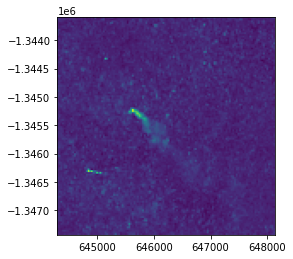

time: 234 ms (started: 2021-12-05 15:44:50 +00:00)


In [ ]:
file = rasterio.open("/content/drive/MyDrive/datasets/landsat_mini/Training/Fire/LC08_L1TP_001068_20180924_20180929_01_T1_bands_f_s128_p02927.tif")
rasterio.plot.show(file)

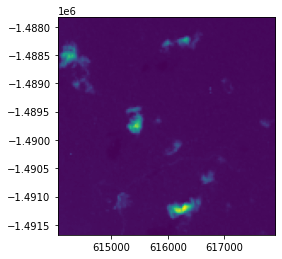

time: 197 ms (started: 2021-12-05 15:44:50 +00:00)


In [ ]:
file = rasterio.open("/content/drive/MyDrive/datasets/landsat_mini/Training/Fire/LC08_L1TP_001069_20180503_20180516_01_T1_bands_f_s128_p03273.tif")
rasterio.plot.show(file)

It's pretty hard to get a feel for multispectral images by looking at all the bands at once! Let's select a few that we expect to use.

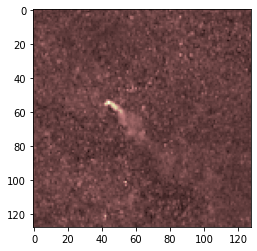

time: 223 ms (started: 2021-12-05 15:44:50 +00:00)


In [ ]:
file = rasterio.open("/content/drive/MyDrive/datasets/landsat_mini/Training/Fire/LC08_L1TP_001068_20180924_20180929_01_T1_bands_f_s128_p02927.tif")
rasterio.plot.show(file.read(2), cmap='pink')

See that plume of smoke? That's the target for our classifier.

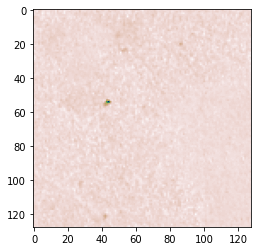

time: 197 ms (started: 2021-12-05 15:44:50 +00:00)


In [ ]:
file = rasterio.open("/content/drive/MyDrive/datasets/landsat_mini/Training/Fire/LC08_L1TP_001068_20180924_20180929_01_T1_bands_f_s128_p02927.tif")
rasterio.plot.show(file.read(6), cmap='gist_earth_r')

There's our fire again, this time on a channel which spots heat data.

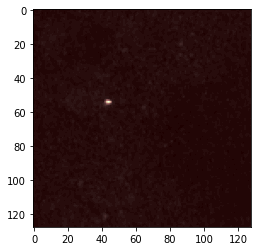

time: 188 ms (started: 2021-12-05 15:51:44 +00:00)


In [ ]:
file = rasterio.open("/content/drive/MyDrive/datasets/landsat_mini/Training/Fire/LC08_L1TP_001068_20180924_20180929_01_T1_bands_f_s128_p02927.tif")
rasterio.plot.show(file.read(7), cmap='pink')

In [ ]:
"""
filtered_images expects torch tensors of dimension [channels, horiz, vert], will reshape
"""

def plot_filter(images, filtered_images):
    
    n_images = images.shape[0]

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        show_img = images[i].squeeze(0)
        show_img = torch.swapaxes(show_img, 0, 1)
        show_img = torch.swapaxes(show_img, 1, 2)
        #bring minimum value to 0 and scale to [0,1] for matplotlib
        #print("before scaling")
        #print(torch.max(show_img), torch.min(show_img))
        show_img = torch.add(show_img, torch.abs(torch.min(show_img)))
        #print("raise floor")
        #print(torch.max(show_img), torch.min(show_img))
        #print("rescale to [0,1]")
        show_img /= (torch.max(show_img)-torch.min(show_img))
        #print(torch.max(show_img), torch.min(show_img))
        ax.imshow(show_img, cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Output')
        ax.axis('off');

time: 21 ms (started: 2021-12-05 15:44:50 +00:00)


We can use the above standard-issue image plotting function to visualize some of the images in our dataset.

In [ ]:
image, label = next(iter(dataloaders[0]))

time: 5.91 ms (started: 2021-12-05 15:44:50 +00:00)


In [ ]:
num_images = len(image)
images = []
for i in range(num_images):
  images.append(image[i])
  print(torch.max(image[i]), torch.min(image[i]))

tensor(-0.3726) tensor(-2.0220)
tensor(0.0907) tensor(-0.7363)
tensor(0.) tensor(-1.)
tensor(0.0921) tensor(-0.7321)
tensor(-0.3338) tensor(-2.0139)
tensor(0.1270) tensor(-0.6710)
tensor(-0.3367) tensor(-2.0043)
tensor(0.0827) tensor(-0.7857)
time: 55.3 ms (started: 2021-12-05 15:44:50 +00:00)


Let's convert to a Torch tensor by adding a singleton dimension.

In [ ]:
images = torch.cat([img.unsqueeze(0) for img in images], dim = 0)

time: 10.4 ms (started: 2021-12-05 15:44:51 +00:00)


Let's examine these images, and while we're at it, let's take a glance at how our convolutional filter is going to process them. 

In [ ]:
filter = [[[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]],
          [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]]]
filter = torch.FloatTensor(filter).unsqueeze(0)

time: 10.7 ms (started: 2021-12-05 15:44:51 +00:00)


The correct size for a conv2d should be:

    input: (batch_size, in_channels , height, width)
    weight: (out_channels, in_channels , kernel_height, kernel_width)


In [ ]:
filtered_images = nn.functional.conv2d(images, filter, stride=(1, 1), padding=2, bias=None)
filtered_images.shape

torch.Size([8, 1, 256, 256])

time: 140 ms (started: 2021-12-05 15:44:51 +00:00)


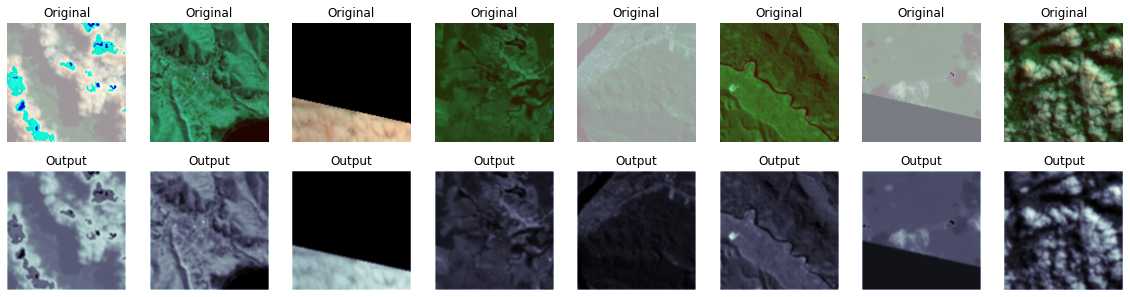

time: 929 ms (started: 2021-12-05 15:44:51 +00:00)


In [ ]:
plot_filter(images, filtered_images)

## Train and Test

In [ ]:
# intialize pretrained models
for i, _ in enumerate(model_names):
  if not os.path.exists(os.path.join(PATH, model_names[i])):
    os.mkdir(os.path.join(PATH, model_names[i]))

time: 6.58 ms (started: 2021-12-05 16:49:09 +00:00)


Model is now satfire_wide_resnet50_2
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:0 -- Phase:0 -- Loss:0.09 -- Acc:87.13
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:1 -- Phase:0 -- Loss:0.06 -- Acc:93.61
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:2 -- Phase:0 -- Loss:0.05 -- Acc:93.96
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:3 -- Phase:0 -- Loss:0.03 -- Acc:97.20
early stopping
Number of batches: 1: 44


0it [00:00, ?it/s]

Phase:1 -- Loss:0.09 -- Acc:97.99
Model is now satfire_densenet161
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:0 -- Phase:0 -- Loss:0.07 -- Acc:89.75
Number of batches: 0: 143


0it [00:00, ?it/s]

Epoch:1 -- Phase:0 -- Loss:0.03 -- Acc:96.58
early stopping
Number of batches: 1: 44


0it [00:00, ?it/s]

Phase:1 -- Loss:0.10 -- Acc:97.42


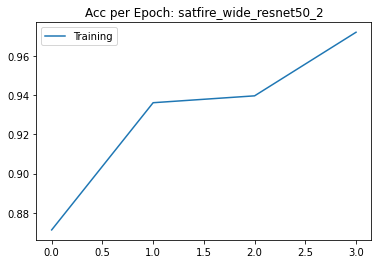

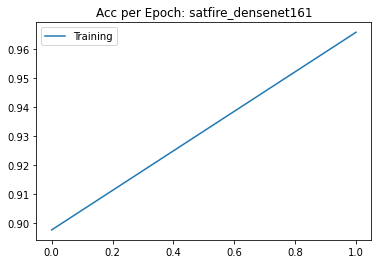

time: 2min 28s (started: 2021-12-05 17:06:39 +00:00)


In [ ]:
for i, model in enumerate(pt_models):
  PREV_ACC = 0
  if i == 0:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.fc.in_features ### Resnet Wide
    model.fc = nn.Linear(num_ftrs, 2)
    #Use pre-loaded model T/F
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/satfire_wide_resnet50_2/satfire_wide_resnet50_2.pt"
    LOAD_MODEL = False
    #Skip this model T/F
    SKIP_MODEL = False
  if i == 1:
    print("Model is now {}".format(model_names[i]))
    num_ftrs = model.classifier.in_features ### Densenet161
    model.classifier = nn.Linear(num_ftrs, 2)
    #Use pre-loaded model T/F
    MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/satfire_densenet161/satfire_densenet161.pt"
    LOAD_MODEL = False
    #Skip this model T/F
    SKIP_MODEL = False
  if SKIP_MODEL:
    continue
  # define loss function, optimizer
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=LR)
  save_loss = {"0":[], "1":[]}
  save_acc = {"0":[], "1":[]}
  
  ###############
  #TRAINING LOOP#
  ###############
  model.train()
  phase = 0
  key = "{}".format(phase)
  for epoch in range(epochs):
      model = model.to(device)
      if LOAD_MODEL:
        model.load_state_dict(torch.load(MODEL_PATH))
        break
      #Early Stopping
      if (PREV_ACC > 99.0 and phase == 0):
        print("early stopping")
        break
      current_loss = 0.0
      current_corrects = 0
      print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
      for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # print(inputs, labels)
          # Time to carry out the forward training poss
          with torch.set_grad_enabled(True):
              outputs = model(inputs)
              # print(outputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              # print(loss)
              loss = loss / accum_iter
              loss.backward()
              if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(dataloaders[phase])):
                optimizer.step()
                optimizer.zero_grad()

          # We want variables to hold the loss/acc statistics
          current_loss += loss.item() * inputs.size(0)
          current_corrects += torch.sum(preds == labels.data)

      # saving variable for plotting
      save_loss[key] += [current_loss / len(dataloaders[phase].dataset)]
      save_acc[key] += [current_corrects.item() / len(dataloaders[phase].dataset)]

      # pretty print
      print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[key][-1]:.2f} -- Acc:{save_acc[key][-1]*100:.2f}")
      # update previous accuracy for early stopping
      PREV_ACC = save_acc[key][-1]*100
  
  #save final results
  torch.save(model.state_dict(), os.path.join(PATH, model_names[i], model_names[i] + '.pt'))

  ###############
  #TESTING  LOOP#
  ###############
  model = model.to(device)
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  phase = 1
  key = "{}".format(phase)
  print("Number of batches: {}: {}".format(phase, len(dataloaders[phase])))
  for batch_idx, (inputs, labels) in tq.tqdm(enumerate(dataloaders[phase], 1)):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
      # saving variable for plottin
  save_loss[key] += [current_loss / len(dataloaders[phase].dataset)]
  save_acc[key] += [current_corrects.item() / len(dataloaders[phase].dataset)]

  # pretty print
  print(f"Phase:{key} -- Loss:{save_loss[key][-1]:.2f} -- Acc:{save_acc[key][-1]*100:.2f}")
  
  #plot and save results
  fig = plt.figure()
  plt.plot(save_acc["0"])
  plt.legend(["Training"])
  plt.title("Acc per Epoch: " + model_names[i])
  fig.savefig(os.path.join(PATH, model_names[i], model_names[i] + '.png'), dpi=100)

  cur_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

  keystr = model_names[i] + cur_time

  rtime = time.time() - start_time

  start_time = time.time()

  results = {"name" : keystr, "classifier" : model_names[i], "dataset" : "satellite", "distributed" : False, "loss_dict" : save_loss, "acc_dict" : save_acc, "runtime" : rtime, "epochs" : epochs, "LR" : LR, "Optim" : "Adam", "batch_size" : ACTUAL_BATCH_SIZE, "Gradient Accumulation" : ACTUAL_BATCH_SIZE > BATCH_SIZE, "Skip Training" : LOAD_MODEL}

  #store in mongoDB
  collection.insert_one(results)

  #store results pickle locally for later upload
  PICKLE_FILE = keystr + ".pkl"

  PICKLE_PATH = os.path.join(PATH, model_names[i], PICKLE_FILE)

  with open(PICKLE_PATH, 'wb') as handle:
      pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for item in results.keys():
  print(item, type(item))

name <class 'str'>
classifier <class 'str'>
dataset <class 'str'>
loss_dict <class 'str'>
acc_dict <class 'str'>
runtime <class 'str'>
epochs <class 'str'>
LR <class 'str'>
Optim <class 'str'>
batch_size <class 'str'>
Gradient Accumulation <class 'str'>
Skip Training <class 'str'>
_id <class 'str'>
time: 6.59 ms (started: 2021-12-05 16:51:57 +00:00)


## Results

### Resnet

Here we can see the power of convolutional classifiers. This was not an easy dataset by any means -- a typical human observer would certainly be capable of spotting the fire in some of these examples if the correct band was isolated, but the model is able to pick the signal out of the noise with impressive speed and accuraacy.

In [ ]:
model = models.wide_resnet50_2(pretrained=True)
num_ftrs = model.fc.in_features ### Resnet Wide
model.fc = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/satfire_wide_resnet50_2/satfire_wide_resnet50_2.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

time: 1.58 s (started: 2021-12-05 17:09:20 +00:00)


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

time: 6.9 ms (started: 2021-12-05 17:09:22 +00:00)


In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

time: 3.79 ms (started: 2021-12-05 17:09:22 +00:00)


In [ ]:
labels, probs = get_predictions(model, dataloaders[1], device)

time: 2.04 s (started: 2021-12-05 17:10:54 +00:00)


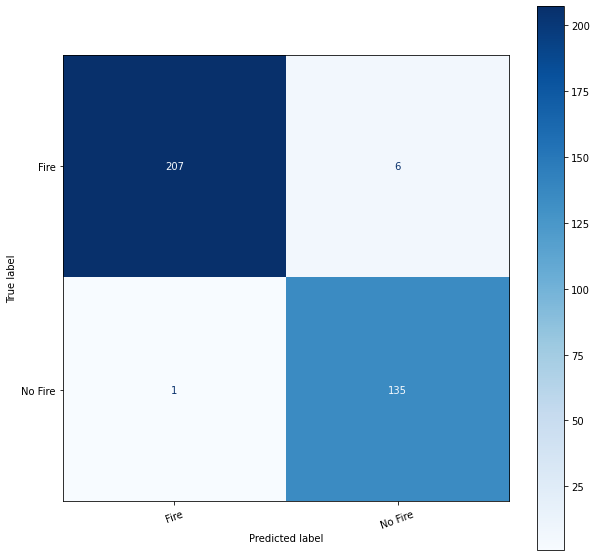

time: 220 ms (started: 2021-12-05 17:10:59 +00:00)


In [ ]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

### Densenet

Densenet and resnet offered comparable performance on this task.

In [ ]:
model = models.densenet161(pretrained=True)
num_ftrs = model.classifier.in_features ### Densenet161
model.classifier = nn.Linear(num_ftrs, 2)
MODEL_PATH = "/content/drive/MyDrive/School/NYU/Big Data Fall 2021/Project/satfire_densenet161/satfire_densenet161.pt"
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

time: 1.24 s (started: 2021-12-05 17:13:10 +00:00)


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, y_pred = torch.max(outputs, 1)
            labels.append(y)
            probs.append(y_pred)
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

time: 6.99 ms (started: 2021-12-05 17:13:11 +00:00)


In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

time: 4.07 ms (started: 2021-12-05 17:13:11 +00:00)


In [ ]:
labels, probs = get_predictions(model, dataloaders[1], device)

time: 2.03 s (started: 2021-12-05 17:13:22 +00:00)


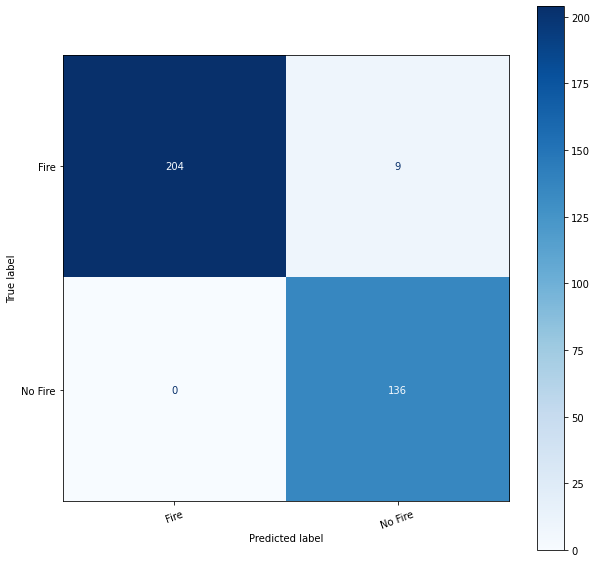

time: 202 ms (started: 2021-12-05 17:13:24 +00:00)


In [ ]:
classes = ["Fire", "No Fire"]
plot_confusion_matrix(labels.cpu(), probs.cpu(), classes) 

# Conclusion

As we can see, it's quite a lot of work comparing and contrasting different models and datasets, particularly when we have to adjust the training loop by hand each time!  We'll see a framework that abstracts away some of this complexity in our next notebook. We'll also get to take a look at a (simulated) distributed computing environment and understand the theoretical benefits of it for deep learning.